In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

In [2]:
holidays_events = pd.read_csv('Data/holidays_events.csv')
oil = pd.read_csv('Data/oil.csv')
stores = pd.read_csv('Data/stores.csv')
test = pd.read_csv('Data/test.csv')
train = pd.read_csv('Data/train.csv')
transactions = pd.read_csv('Data/transactions.csv')

In [3]:
holidays_events["date"] = pd.to_datetime(holidays_events.date)
oil["date"] = pd.to_datetime(oil.date)
test["date"] = pd.to_datetime(test.date)
train["date"] = pd.to_datetime(train.date)
transactions["date"] = pd.to_datetime(transactions.date)

In [4]:
oil['dcoilwtico'].fillna(np.nanmedian(oil.dcoilwtico), inplace = True)
oil.head(3)

,date,dcoilwtico
0,2013-01-01,53.19
1,2013-01-02,93.14
2,2013-01-03,92.97


In [5]:
stores.head(3)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8


In [6]:
train.head(3)

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0


In [7]:
test.head(3)

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2


In [8]:
transactions.head(3)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358


<function matplotlib.pyplot.plot(*args, scalex=True, scaley=True, data=None, **kwargs)>

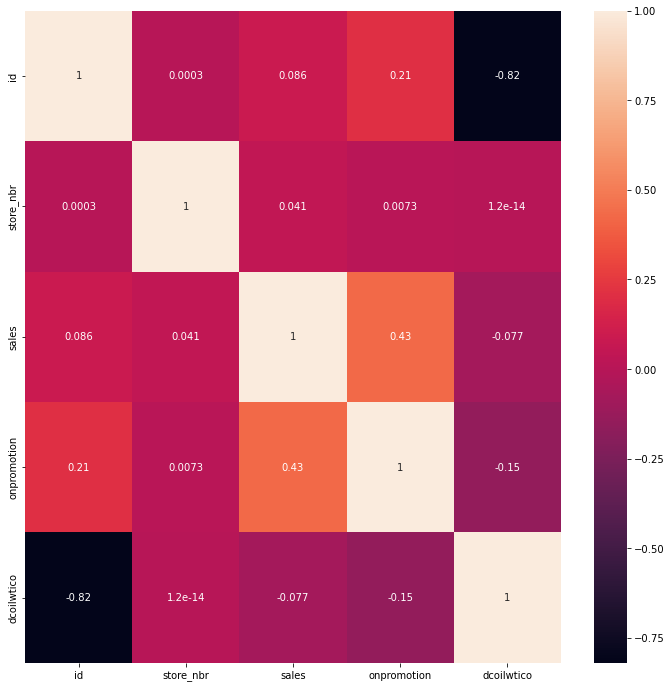

In [9]:
#Relation of features of train and oil dataframes with sales 
plt.figure(figsize=(12, 12))
train_oil = pd.merge(train, oil, how='left')
sns.heatmap(train_oil.corr(), annot=True)
plt.plot

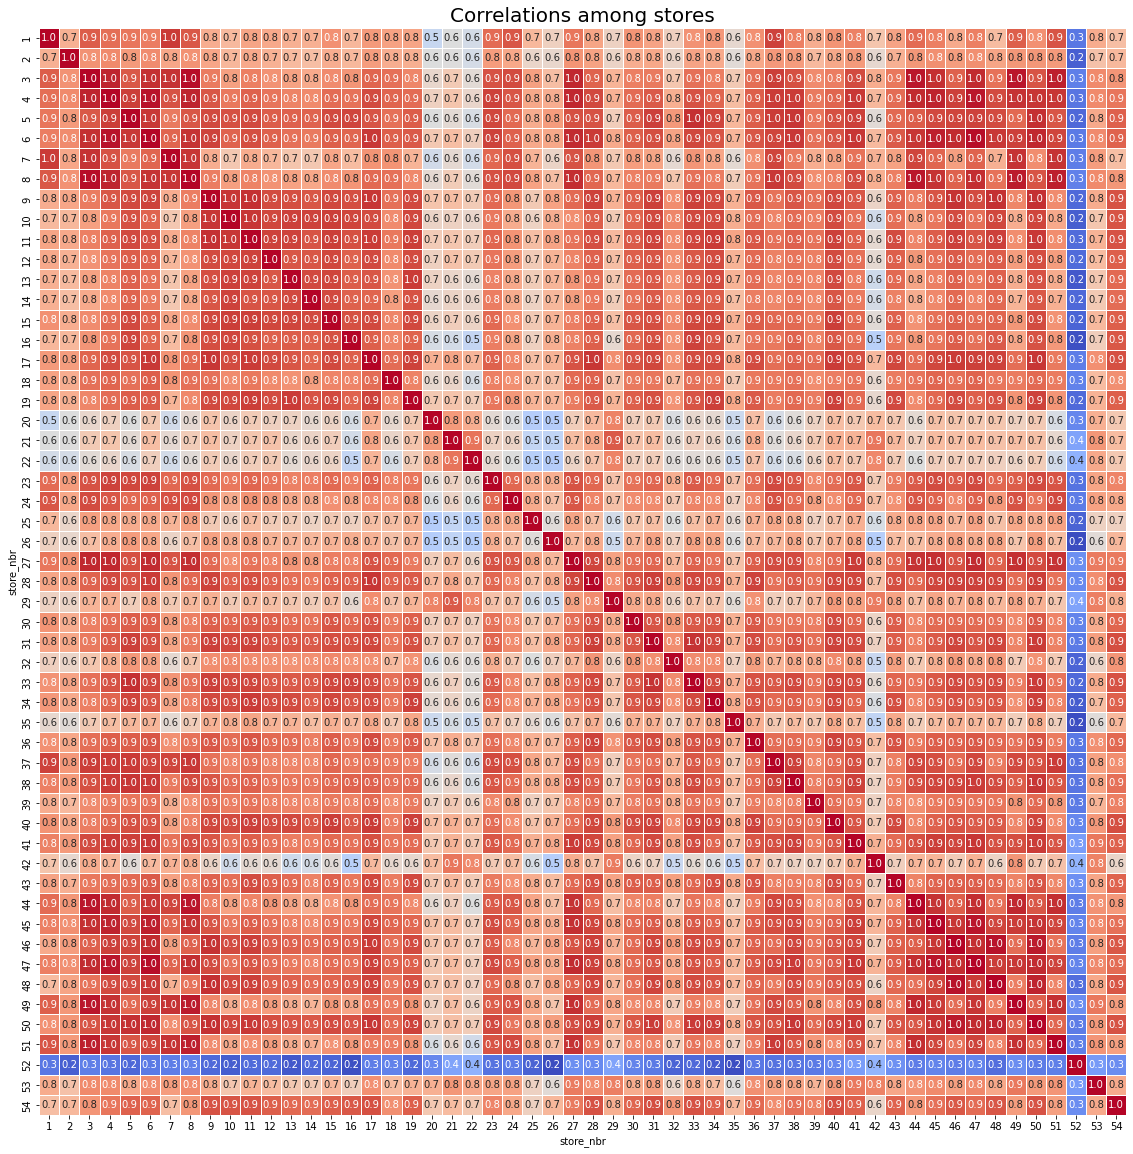

In [10]:
#Is there co-relation of store_nbr with each other w.r.t sales
a = train[["store_nbr", "sales"]]
a["ind"] = 1
a["ind"] = a.groupby("store_nbr").ind.cumsum().values
a = pd.pivot(a, index = "ind", columns = "store_nbr", values = "sales").corr()
plt.figure(figsize=(20, 20))
sns.heatmap(a,
        annot=True,
        fmt='.1f',
        cmap='coolwarm',
        square=True,
        linewidths=1,
        cbar=False)
plt.title("Correlations among stores",fontsize = 20)
plt.show()

In [11]:
train.shape

(3000888, 6)

In [12]:
train = train[~((train.store_nbr == 52) & (train.date < "2017-04-20"))]
train = train[~((train.store_nbr == 22) & (train.date < "2015-10-09"))]
train = train[~((train.store_nbr == 42) & (train.date < "2015-08-21"))]
train = train[~((train.store_nbr == 21) & (train.date < "2015-07-24"))]
train = train[~((train.store_nbr == 29) & (train.date < "2015-03-20"))]
train = train[~((train.store_nbr == 20) & (train.date < "2015-02-13"))]
train = train[~((train.store_nbr == 53) & (train.date < "2014-05-29"))]
train = train[~((train.store_nbr == 36) & (train.date < "2013-05-09"))]
train.shape

(2780316, 6)

In [13]:
# Stores which never sold products of particular family type.
sales_dependednt_on_family = train.groupby(["store_nbr", "family"]).sales.sum().reset_index().sort_values(["family","store_nbr"])
sales_dependednt_on_family = sales_dependednt_on_family[sales_dependednt_on_family.sales == 0]
sales_dependednt_on_family

,store_nbr,family,sales
1,1,BABY CARE,0.0
397,13,BABY CARE,0.0
727,23,BABY CARE,0.0
1420,44,BABY CARE,0.0
1453,45,BABY CARE,0.0
1486,46,BABY CARE,0.0
1519,47,BABY CARE,0.0
1552,48,BABY CARE,0.0
1585,49,BABY CARE,0.0
1618,50,BABY CARE,0.0


In [14]:
#Remove the entries from train where sales for a family type will always be zero, as calculated above
outer_join = train.merge(sales_dependednt_on_family.drop("sales",axis = 1), how = 'outer', indicator = True)
train = outer_join[~(outer_join._merge == 'both')].drop('_merge', axis = 1)
del outer_join
train.shape

(2698648, 6)

In [15]:
#If we need to predict sales of product 'A' by store '1' when '1' never sold it, it will automatically return 0. 
zero_prediction = []
for i in range(0,len(sales_dependednt_on_family)):
    zero_prediction.append(
        pd.DataFrame({
            "date":pd.date_range("2017-08-16", "2017-08-31").tolist(),
            "store_nbr":sales_dependednt_on_family.store_nbr.iloc[i],
            "family":sales_dependednt_on_family.family.iloc[i],
            "sales":0
        })
    )
zero_prediction = pd.concat(zero_prediction)
del sales_dependednt_on_family
zero_prediction

,date,store_nbr,family,sales
0,2017-08-16,1,BABY CARE,0
1,2017-08-17,1,BABY CARE,0
2,2017-08-18,1,BABY CARE,0
3,2017-08-19,1,BABY CARE,0
4,2017-08-20,1,BABY CARE,0
...,...,...,...,...
11,2017-08-27,54,LAWN AND GARDEN,0
12,2017-08-28,54,LAWN AND GARDEN,0
13,2017-08-29,54,LAWN AND GARDEN,0
14,2017-08-30,54,LAWN AND GARDEN,0


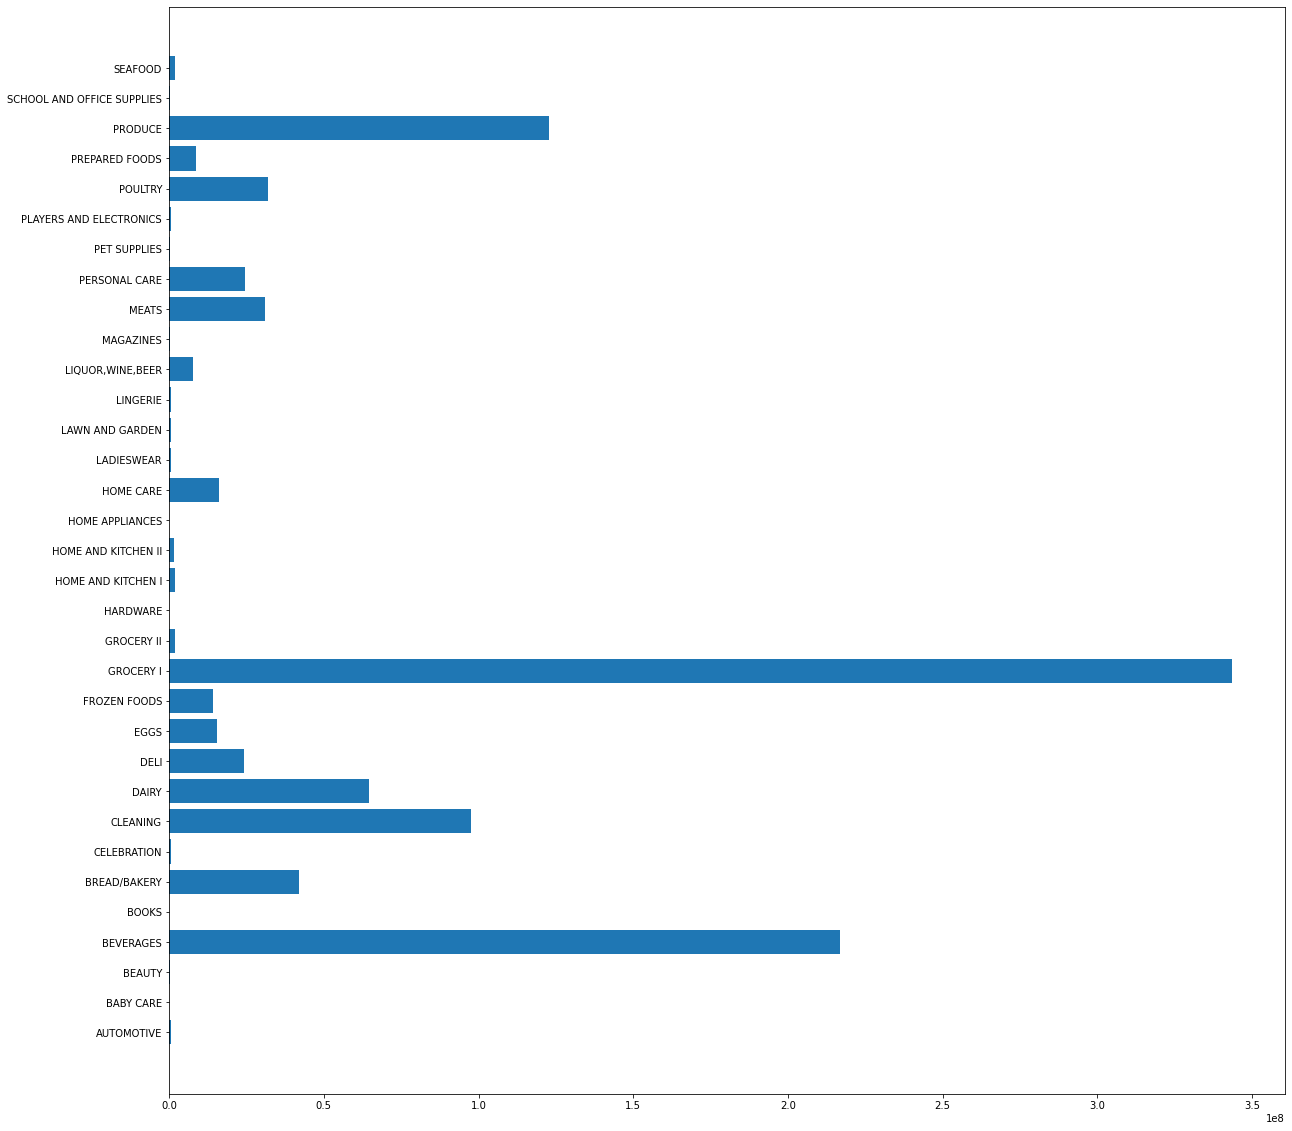

In [16]:
# Product from which family type is sold the most.
pd.set_option('display.float_format', lambda x: '%.3f' % x)
plt.figure(figsize=(20, 20))
train_family = train.set_index("date").groupby("family").resample("D").sales.sum().reset_index()
grp_by = train_family.groupby('family')['sales'].sum().reset_index()
plt.barh(grp_by['family'],grp_by['sales'])
plt.show()

In [17]:
#Merged train and store and added a new column - 'year'
train_sales = pd.merge(train, stores)
train_sales["store_nbr"] = train_sales["store_nbr"].astype("int8")
train_sales["year"] = (train_sales.date.dt.year).astype('Int64', errors='ignore')
train_sales.head(2)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,year
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,2013
1,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13,2013


In [18]:
sales_perCity_perYr = train_sales.groupby(["city", "year"]).sales.mean().reset_index()

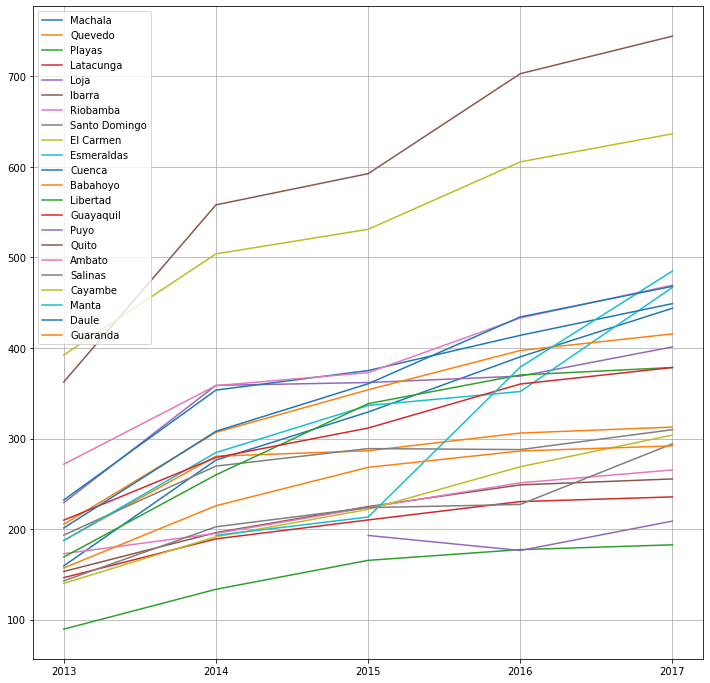

In [19]:
cities = set(sales_perCity_perYr['city'])
plt.figure(figsize=(12, 12))

for city in cities:
     selected_data = sales_perCity_perYr.loc[sales_perCity_perYr['city'] == city]
     plt.plot(selected_data['year'], selected_data['sales'], label=city)

plt.xticks([2013, 2014, 2015, 2016, 2017])
plt.grid()
plt.legend()
plt.show()

In [20]:
holidays_events.head(3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False


In [21]:
holidays_events.shape

(350, 6)

In [22]:
holidays_events['type'].unique()

array(['Holiday', 'Transfer', 'Additional', 'Bridge', 'Work Day', 'Event'],
      dtype=object)

In [23]:
# Transferred Holidays - A holiday reschedules to some other day
tr1 = holidays_events[(holidays_events.type == "Holiday") & (holidays_events.transferred == True)].drop("transferred", axis = 1).reset_index(drop = True)
tr2 = holidays_events[(holidays_events.type == "Transfer")].drop("transferred", axis = 1).reset_index(drop = True)
# So transfered_holidays -> when people were actually getting holiday with proper details.
transfered_holidays = tr1[['type', 'locale', 'locale_name', 'description']]
transfered_holidays['date'] = tr2['date']
transfered_holidays.head(3)

,type,locale,locale_name,description,date
0,Holiday,National,Ecuador,Independencia de Guayaquil,2012-10-12
1,Holiday,National,Ecuador,Independencia de Guayaquil,2013-10-11
2,Holiday,National,Ecuador,Independencia de Guayaquil,2014-10-10


In [24]:
holidays = holidays_events[(holidays_events['transferred'] == False) & (holidays_events['type'] != "Transfer")].drop("transferred", axis = 1)
holidays = holidays.append(transfered_holidays).reset_index(drop = True)
holidays.head(3)

,date,type,locale,locale_name,description
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca


In [25]:
holidays["description"] = holidays["description"].str.replace("-", "").str.replace("+", "").str.replace('\d+', '')
holidays["type"] = np.where(holidays["type"] == "Additional", "Holiday", holidays["type"])

In [26]:
holidays["description"] = holidays["description"].str.replace("Puente ", "")
holidays["type"] = np.where(holidays["type"] == "Bridge", "Holiday", holidays["type"])

In [27]:
holidays["type"].unique()

array(['Holiday', 'Work Day', 'Event'], dtype=object)

In [28]:
work_day = holidays[holidays.type == "Work Day"]  
holidays = holidays[holidays.type != "Work Day"]  

In [29]:
events = holidays[holidays.type == "Event"].drop(["type", "locale", "locale_name"], axis = 1).rename({"description":"events"}, axis = 1)
holidays = holidays[holidays.type != "Event"].drop("type", axis = 1)
events.head(3)

,date,events
53,2013-05-12,Dia de la Madre
99,2014-05-11,Dia de la Madre
102,2014-06-12,Inauguracion Mundial de futbol Brasil


In [30]:
holidays.head(2)

,date,locale,locale_name,description
0,2012-03-02,Local,Manta,Fundacion de Manta
1,2012-04-01,Regional,Cotopaxi,Provincializacion de Cotopaxi


In [31]:
holidays["locale"].unique()

array(['Local', 'Regional', 'National'], dtype=object)

In [32]:
local = holidays[holidays.locale == "Local"].rename({"description":"holiday_local", "locale_name":"city"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
local.head(3)

,date,city,holiday_local
0,2012-03-02,Manta,Fundacion de Manta
2,2012-04-12,Cuenca,Fundacion de Cuenca
3,2012-04-14,Libertad,Cantonizacion de Libertad


In [33]:
regional = holidays[holidays['locale'] == "Regional"].rename({"locale_name":"state", "description":"holiday_regional"}, axis = 1).drop("locale", axis = 1).drop_duplicates()
regional.head(3)

,date,state,holiday_regional
1,2012-04-01,Cotopaxi,Provincializacion de Cotopaxi
7,2012-06-25,Imbabura,Provincializacion de Imbabura
21,2012-11-06,Santo Domingo de los Tsachilas,Provincializacion de Santo Domingo


In [34]:
national = holidays[holidays.locale == "National"].rename({"description":"holiday_national"}, axis = 1).drop(["locale", "locale_name"], axis = 1).drop_duplicates()
national.head(3)

,date,holiday_national
14,2012-08-10,Primer Grito de Independencia
19,2012-11-02,Dia de Difuntos
20,2012-11-03,Independencia de Cuenca


In [35]:
print(train.shape)
print(test.shape)

(2698648, 6)
(28512, 5)


In [36]:
df = pd.merge(train.append(test), stores)
df["store_nbr"] = df["store_nbr"].astype("int8")
df.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13
1,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13
2,3564,2013-01-03,1,AUTOMOTIVE,3.000,0,Quito,Pichincha,D,13


In [37]:
df = pd.merge(df, national, how = "left")
df = pd.merge(df, regional, how = "left", on = ["date", "state"])
df = pd.merge(df, local, how = "left", on = ["date", "city"])

In [38]:
df = pd.merge(df, work_day[["date", "type"]].rename({"type":"IsWorkDay"}, axis = 1),how = "left")

In [39]:
df.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,holiday_national,holiday_regional,holiday_local,IsWorkDay
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,Primer dia del ano,NaN,NaN,NaN
1,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN
2,3564,2013-01-03,1,AUTOMOTIVE,3.000,0,Quito,Pichincha,D,13,NaN,NaN,NaN,NaN


In [40]:
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    #dummy_na : If true, it will create new column when nan = True
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    df.columns = df.columns.str.replace(" ", "_")
    return df, df.columns.tolist()

In [41]:
events, events_cat = one_hot_encoder(events, nan_as_category=False)

In [42]:
events[events['date'].duplicated(keep=False)]

,date,events_Black_Friday,events_Cyber_Monday,events_Dia_de_la_Madre,events_Inauguracion_Mundial_de_futbol_Brasil,events_Mundial_de_futbol_Brasil:_Cuartos_de_Final,events_Mundial_de_futbol_Brasil:_EcuadorFrancia,events_Mundial_de_futbol_Brasil:_EcuadorHonduras,events_Mundial_de_futbol_Brasil:_EcuadorSuiza,events_Mundial_de_futbol_Brasil:_Final,events_Mundial_de_futbol_Brasil:_Octavos_de_Final,events_Mundial_de_futbol_Brasil:_Semifinales,events_Mundial_de_futbol_Brasil:_Tercer_y_cuarto_lugar,events_Terremoto_Manabi
238,2016-05-08,0,0,0,0,0,0,0,0,0,0,0,0,1
239,2016-05-08,0,0,1,0,0,0,0,0,0,0,0,0,0


In [43]:
#Because of 2016.05.08, there were two events. pd.dummied would have created duplicate entries, so here marking 2nd one as True as well
events["events_Dia_de_la_Madre"] = np.where(events.date == "2016-05-08", 1,events["events_Dia_de_la_Madre"])
events = events.drop(239)

In [44]:
df = df.merge(events, how = 'left')

In [45]:
df.head(2)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,events_Inauguracion_Mundial_de_futbol_Brasil,events_Mundial_de_futbol_Brasil:_Cuartos_de_Final,events_Mundial_de_futbol_Brasil:_EcuadorFrancia,events_Mundial_de_futbol_Brasil:_EcuadorHonduras,events_Mundial_de_futbol_Brasil:_EcuadorSuiza,events_Mundial_de_futbol_Brasil:_Final,events_Mundial_de_futbol_Brasil:_Octavos_de_Final,events_Mundial_de_futbol_Brasil:_Semifinales,events_Mundial_de_futbol_Brasil:_Tercer_y_cuarto_lugar,events_Terremoto_Manabi
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [46]:
# Filling Null values
df[events_cat] = df[events_cat].fillna(0)

# Adding New features as binarised holiday types
df["holiday_national_binary"] = np.where(df.holiday_national.notnull(), 1, 0)
df["holiday_local_binary"] = np.where(df.holiday_local.notnull(), 1, 0)
df["holiday_regional_binary"] = np.where(df.holiday_regional.notnull(), 1, 0)
df.head(3)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,events_Mundial_de_futbol_Brasil:_EcuadorHonduras,events_Mundial_de_futbol_Brasil:_EcuadorSuiza,events_Mundial_de_futbol_Brasil:_Final,events_Mundial_de_futbol_Brasil:_Octavos_de_Final,events_Mundial_de_futbol_Brasil:_Semifinales,events_Mundial_de_futbol_Brasil:_Tercer_y_cuarto_lugar,events_Terremoto_Manabi,holiday_national_binary,holiday_local_binary,holiday_regional_binary
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1,0,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0
2,3564,2013-01-03,1,AUTOMOTIVE,3.000,0,Quito,Pichincha,D,13,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0,0,0


In [47]:
#Converting holiday types to binaries
df["national_independence"] = np.where(df.holiday_national.isin(['Batalla de Pichincha','Independencia de Cuenca','Independencia de Guayaquil','Independencia de Guayaquil','Primer Grito de Independencia']), 1, 0)
df["local_cantonizacio"] = np.where(df.holiday_local.str.contains("Cantonizacio"), 1, 0)
df["local_fundacion"] = np.where(df.holiday_local.str.contains("Fundacion"), 1, 0)
df["local_independencia"] = np.where(df.holiday_local.str.contains("Independencia"), 1, 0)

In [48]:
holidays, holidays_cat = one_hot_encoder(df[["holiday_national","holiday_regional","holiday_local"]], nan_as_category=False)

In [49]:
df = pd.concat([df.drop(["holiday_national","holiday_regional","holiday_local"], axis = 1), holidays], axis = 1)

In [50]:
# Ensured that all dummies are int8 type
he_cols = df.columns[df.columns.str.startswith("events")].tolist() + df.columns[df.columns.str.startswith("holiday")].tolist() + df.columns[df.columns.str.startswith("national")].tolist()+ df.columns[df.columns.str.startswith("local")].tolist()
df[he_cols] = df[he_cols].astype("int8")

In [51]:
# Ensuring category type of certain features
df[["family", "city", "state", "type"]] = df[["family", "city", "state", "type"]].astype("category")

In [52]:
del holidays, holidays_cat, work_day, local, regional, national, events, events_cat, transfered_holidays, tr1, tr2, he_cols

In [53]:
df.head()

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,holiday_local_Fundacion_de_Ibarra,holiday_local_Fundacion_de_Loja,holiday_local_Fundacion_de_Machala,holiday_local_Fundacion_de_Manta,holiday_local_Fundacion_de_Quito,holiday_local_Fundacion_de_Riobamba,holiday_local_Fundacion_de_Santo_Domingo,holiday_local_Independencia_de_Ambato,holiday_local_Independencia_de_Guaranda,holiday_local_Independencia_de_Latacunga
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
2,3564,2013-01-03,1,AUTOMOTIVE,3.000,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
3,5346,2013-01-04,1,AUTOMOTIVE,3.000,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0
4,7128,2013-01-05,1,AUTOMOTIVE,5.000,0,Quito,Pichincha,D,13,...,0,0,0,0,0,0,0,0,0,0


In [54]:
#Fetching info from data
def create_date_features(df):
    df['month'] = df.date.dt.month.astype("int8")
    df['day_of_month'] = df.date.dt.day.astype("int8")  
    df['day_of_week'] = (df.date.dt.dayofweek + 1).astype("int8")
    df['year'] = df.date.dt.year.astype("int32")
    df["is_wknd"] = (df.date.dt.weekday // 4).astype("int8")
    df['is_month_start'] = df.date.dt.is_month_start.astype("int8")
    df['is_month_end'] = df.date.dt.is_month_end.astype("int8")
    df['is_year_start'] = df.date.dt.is_year_start.astype("int8")
    df['is_year_end'] = df.date.dt.is_year_end.astype("int8")
    # 0: Winter - 1: Spring - 2: Summer - 3: Fall
    df["season"] = np.where(df.month.isin([12,1,2]), 0, 1)
    df["season"] = np.where(df.month.isin([6,7,8]), 2, df["season"])
    df["season"] = pd.Series(np.where(df.month.isin([9, 10, 11]), 3, df["season"])).astype("int8")
    df['day_of_year'] = df.date.dt.dayofyear.astype("int16")
#     df['week_of_month'] = (df.date.apply(lambda d: (d.day-1) // 7 + 1)).astype("int8")
#     df['week_of_year'] = (df.date.dt.weekofyear).astype("int8")
#     df["quarter"] = df.date.dt.quarter.astype("int8")
#     df["quarter"] = df.date.dt.quarter.astype("int8")
#     df['is_quarter_start'] = df.date.dt.is_quarter_start.astype("int8")
#     df['is_quarter_end'] = df.date.dt.is_quarter_end.astype("int8")
    return df
df = create_date_features(df)

In [55]:
df["workday"] = np.where((df.holiday_national_binary == 1) | (df.holiday_local_binary==1) | (df.holiday_regional_binary==1) | (df['day_of_week'].isin([6,7])), 0, 1)
df.drop("IsWorkDay", axis = 1, inplace = True)

In [56]:
df["wageday"] = pd.Series(np.where((df['is_month_end'] == 1) | (df["day_of_month"] == 15), 1, 0)).astype("int8")

In [57]:
df.head(2)

,id,date,store_nbr,family,sales,onpromotion,city,state,type,cluster,...,year,is_wknd,is_month_start,is_month_end,is_year_start,is_year_end,season,day_of_year,workday,wageday
0,0,2013-01-01,1,AUTOMOTIVE,0.000,0,Quito,Pichincha,D,13,...,2013,0,1,0,1,0,0,1,0,0
1,1782,2013-01-02,1,AUTOMOTIVE,2.000,0,Quito,Pichincha,D,13,...,2013,0,0,0,0,0,0,2,1,0


As there was Earthquack April 16, 2016, so looking into mean data of March, Apr-May and June too see if there is drop/hike in sales that could act as outlier.

In [58]:
df[(df['month'].isin([4,5]))].groupby(["year"]).sales.mean()

year
2013   249.381
2014   285.527
2015   334.683
2016   489.896
2017   503.501
Name: sales, dtype: float64

In [59]:
pd.pivot_table(df[(df['month'].isin([3]))], index="year", columns="family", values="sales", aggfunc="mean")

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
year,,,,,,,,,,,,,,,,,,,,,
2013,5.354,0.000,2.736,1277.854,0.000,416.567,0.000,1055.673,429.529,229.493,...,0.000,368.537,223.881,0.000,0.000,223.562,106.077,2.831,0.000,28.105
2014,6.942,0.065,3.546,3040.627,0.000,446.922,14.741,1215.013,815.257,261.286,...,1.345,382.588,265.746,5.498,11.023,449.169,112.422,2300.855,1.534,27.449
2015,7.547,0.000,2.775,1515.372,0.000,547.433,0.000,1219.262,806.565,329.612,...,0.000,356.967,316.617,0.000,0.000,420.885,104.590,4.510,0.000,28.614
2016,7.339,0.339,4.341,3023.503,0.000,501.947,14.234,1077.721,859.318,277.812,...,6.072,330.770,296.473,5.890,8.719,374.967,109.855,2304.816,1.959,23.892
2017,7.787,0.339,4.292,3733.142,0.586,584.241,14.211,1220.105,991.143,326.488,...,6.278,374.282,331.435,8.791,11.391,395.345,114.028,2442.189,5.019,25.537


In [60]:
pd.pivot_table(df[(df['month'].isin([4,5]))], index="year", columns="family", values="sales", aggfunc="mean")

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
year,,,,,,,,,,,,,,,,,,,,,
2013,5.839,0.000,2.611,1260.956,0.000,418.759,0.000,1027.756,408.359,234.520,...,0.000,377.752,224.648,0.000,0.000,221.587,96.677,5.353,0.000,25.365
2014,5.749,0.000,2.614,1461.639,0.000,416.342,0.000,1028.076,766.628,253.547,...,0.000,361.611,266.436,0.000,0.000,405.267,103.466,5.661,0.000,23.629
2015,6.025,0.000,2.964,1915.163,0.000,551.603,0.000,1227.912,811.308,329.802,...,1.685,365.245,314.394,0.061,0.000,415.488,102.437,5.684,0.000,27.046
2016,7.260,0.320,4.873,3369.272,0.000,551.904,14.247,1218.346,911.856,299.280,...,6.775,363.500,363.466,6.843,10.669,399.369,108.666,2305.699,5.994,24.551
2017,7.630,0.225,5.303,3592.938,0.259,557.840,13.722,1308.013,970.850,323.207,...,6.868,362.407,326.001,9.067,12.220,385.388,96.312,2404.912,11.709,23.172


In [61]:
pd.pivot_table(df[(df['month'].isin([6]))], index="year", columns="family", values="sales", aggfunc="mean")

family,AUTOMOTIVE,BABY CARE,BEAUTY,BEVERAGES,BOOKS,BREAD/BAKERY,CELEBRATION,CLEANING,DAIRY,DELI,...,MAGAZINES,MEATS,PERSONAL CARE,PET SUPPLIES,PLAYERS AND ELECTRONICS,POULTRY,PREPARED FOODS,PRODUCE,SCHOOL AND OFFICE SUPPLIES,SEAFOOD
year,,,,,,,,,,,,,,,,,,,,,
2013,5.894,0.000,2.725,1297.238,0.000,431.054,0.000,1052.438,419.077,238.234,...,0.000,389.954,216.117,0.000,0.000,232.164,100.715,6.121,0.000,20.985
2014,5.715,0.000,2.462,1458.943,0.000,450.818,0.000,1029.449,757.823,260.013,...,0.000,383.369,270.099,0.000,0.000,409.029,101.039,5.752,0.000,23.972
2015,6.522,0.177,3.787,3178.151,0.000,549.952,14.744,1177.297,829.059,328.153,...,1.533,376.676,297.363,5.873,8.723,411.016,108.225,2346.144,1.329,25.854
2016,6.249,0.346,4.548,2806.966,0.000,550.809,13.965,1108.433,863.919,280.656,...,5.674,350.659,292.735,5.952,8.501,373.234,104.964,2239.027,1.548,23.176
2017,7.380,0.234,5.432,3580.135,0.077,555.641,13.798,1228.700,932.528,317.703,...,6.188,388.383,319.435,9.217,11.339,406.582,90.897,2403.450,1.577,19.362


No major drop or hike

In [62]:
df.to_csv('Data/final_data.csv')

In [63]:
# df = pd.read_csv('Data/final_data.csv')

Plotting ACF, PACF Graph.

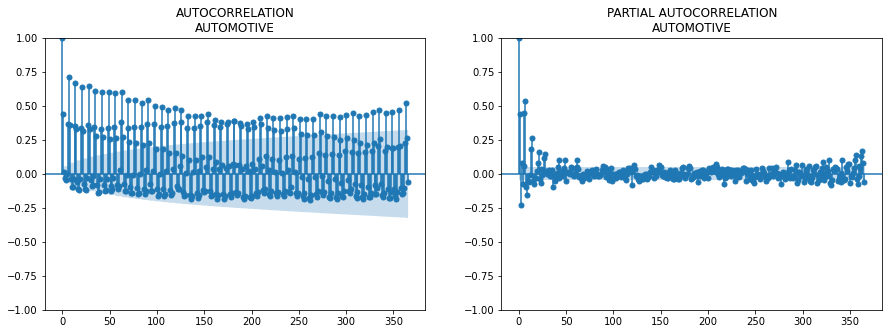

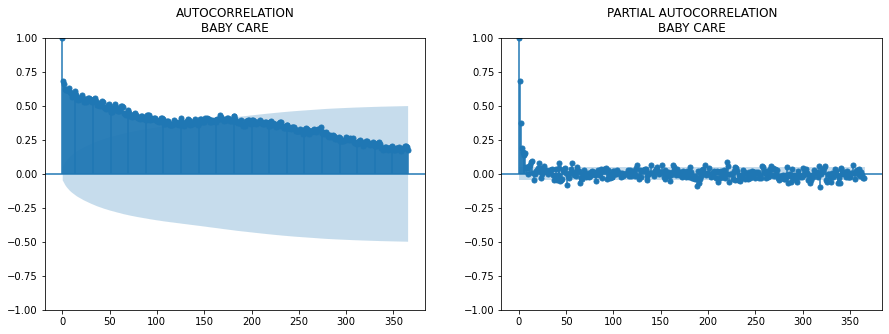

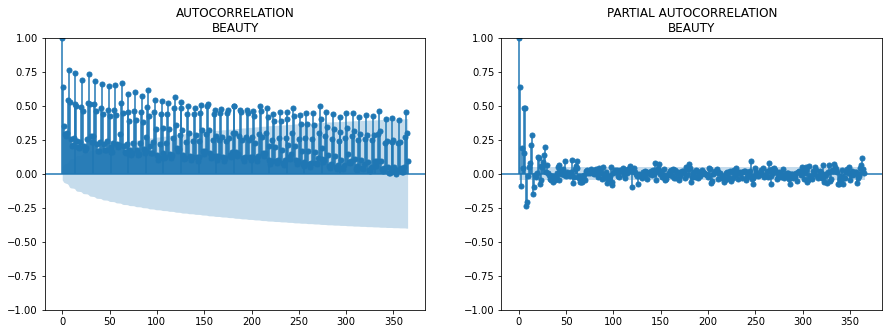

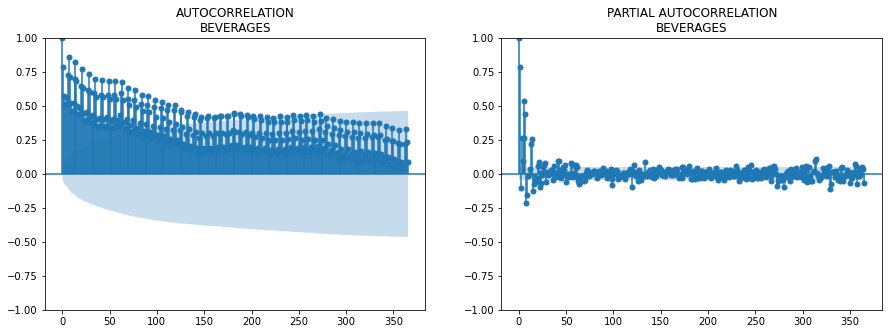

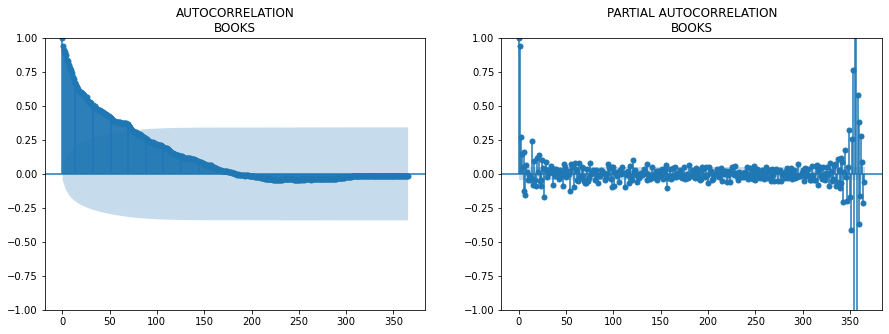

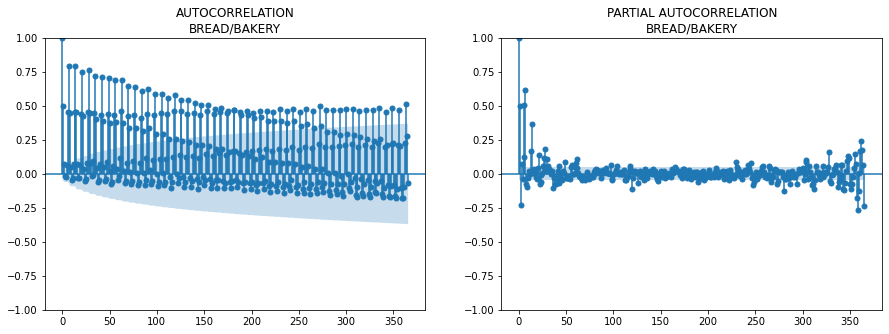

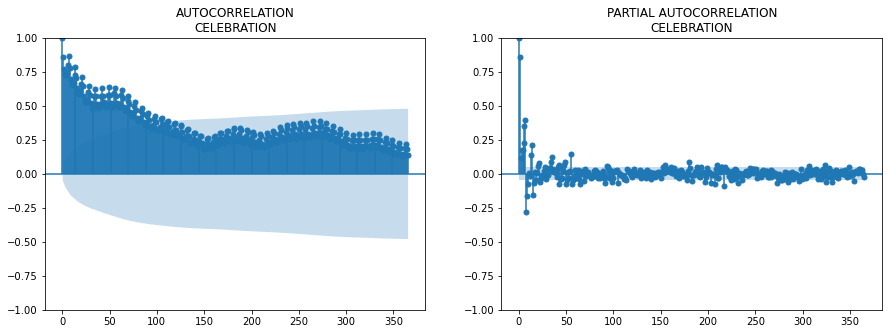

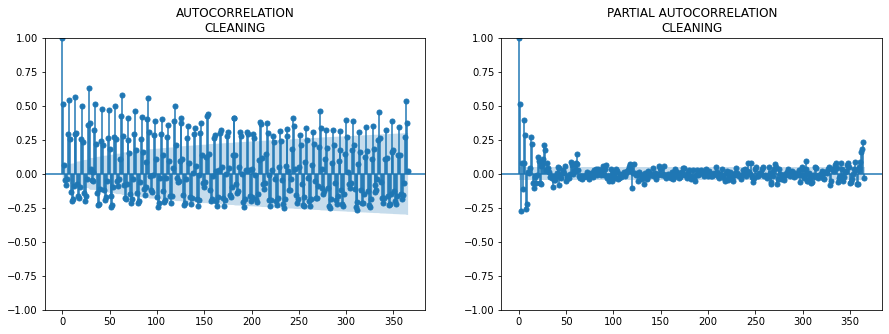

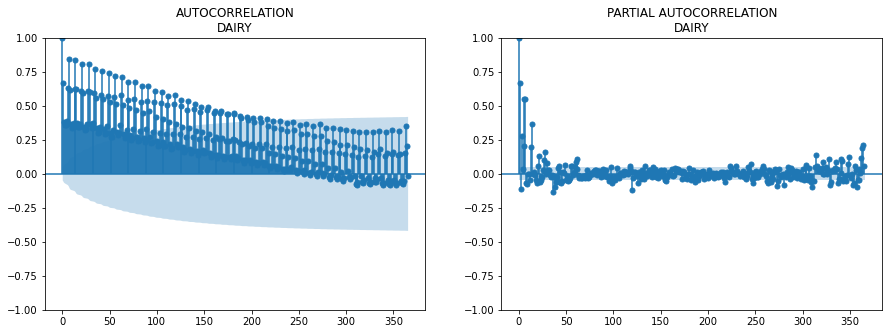

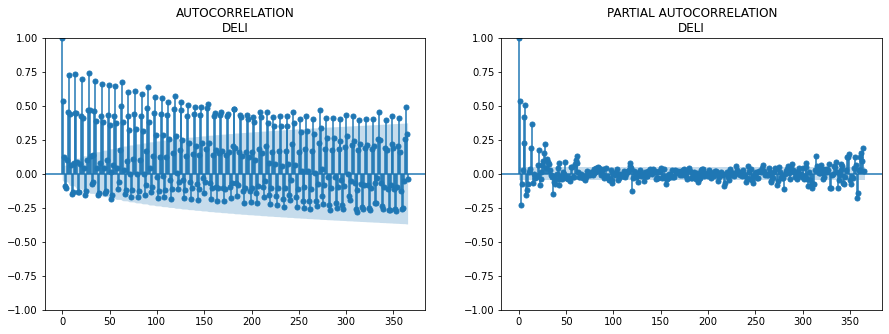

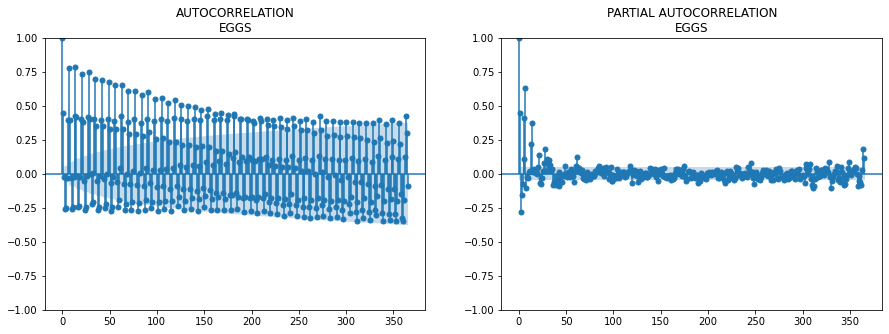

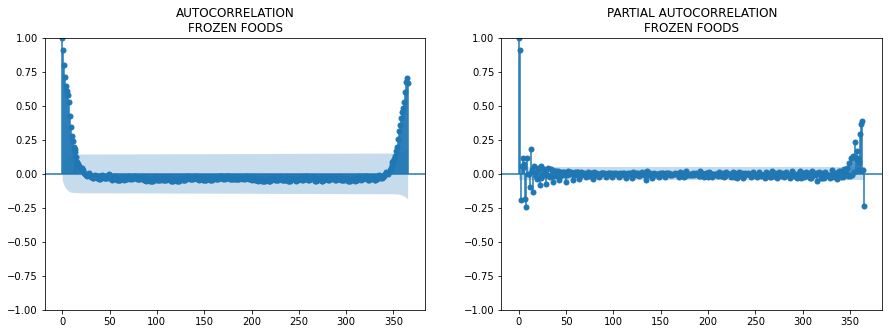

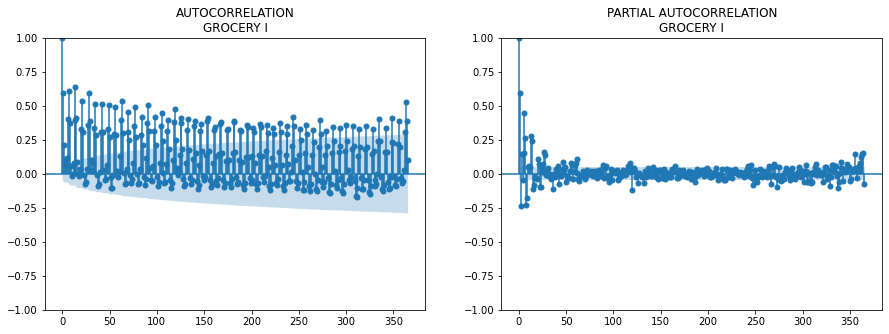

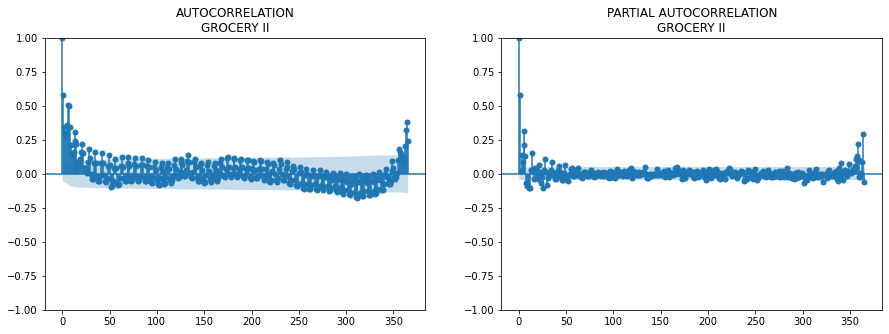

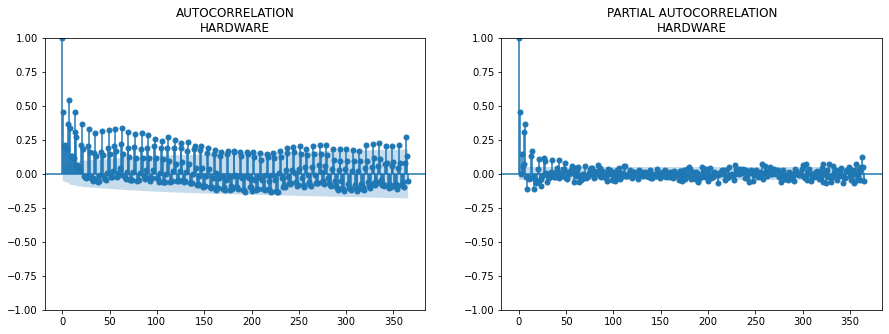

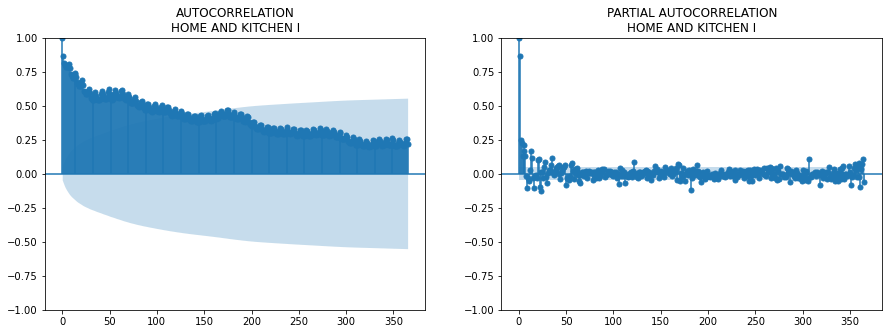

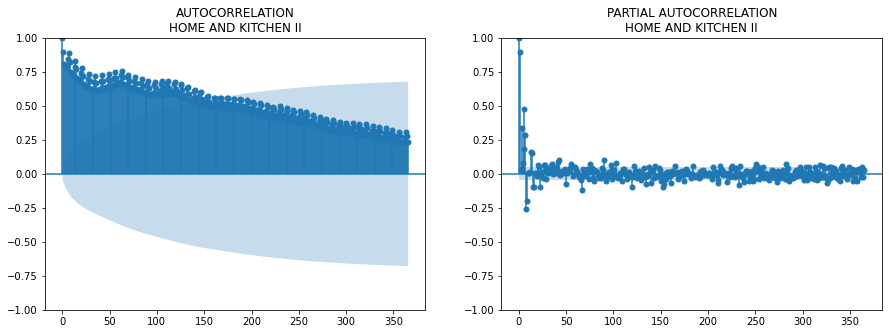

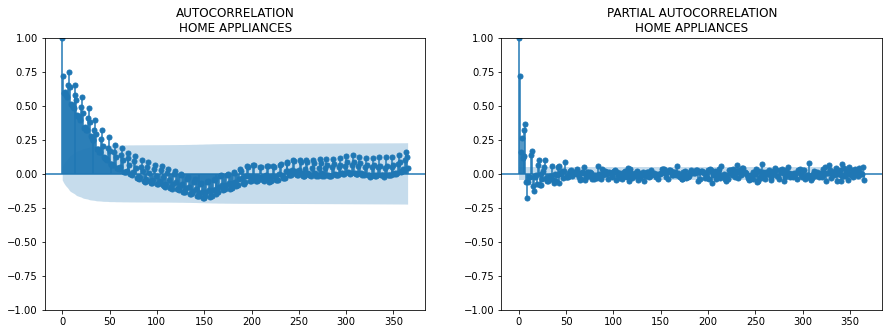

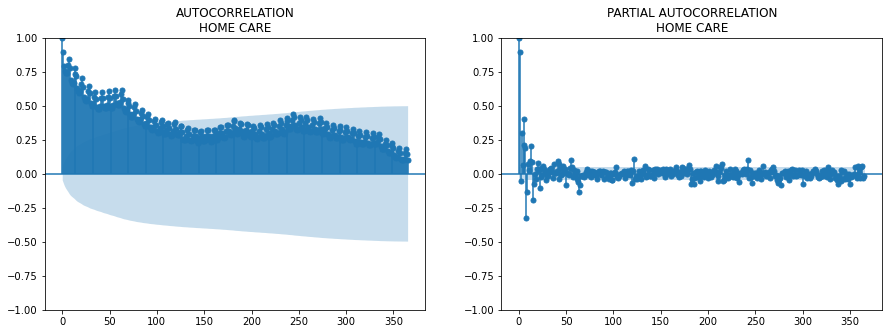

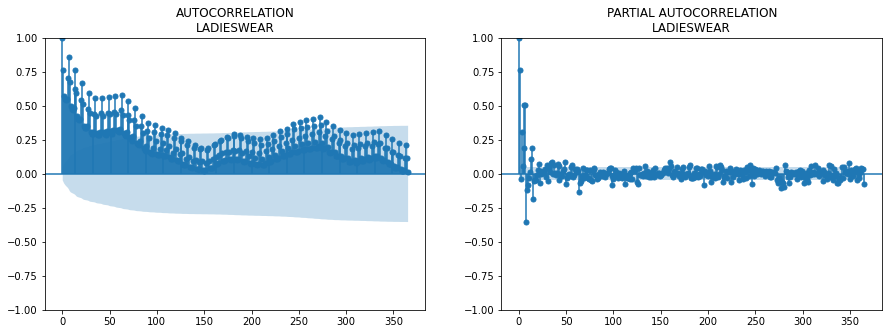

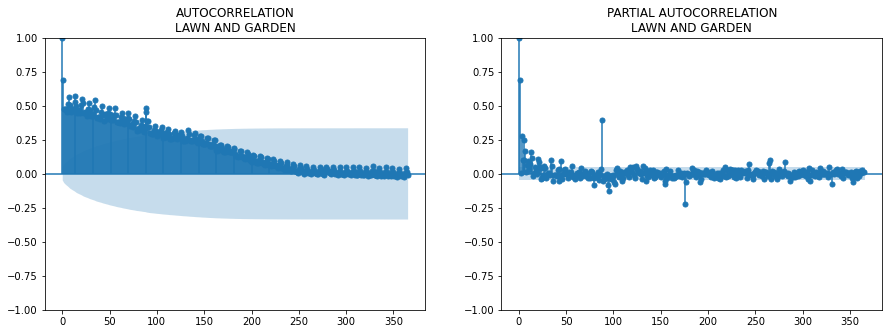

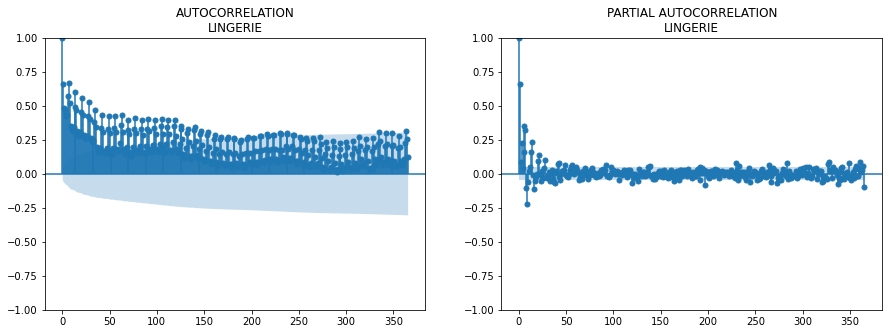

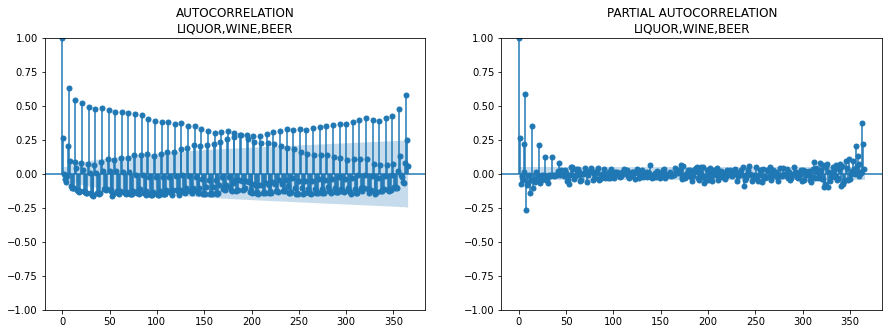

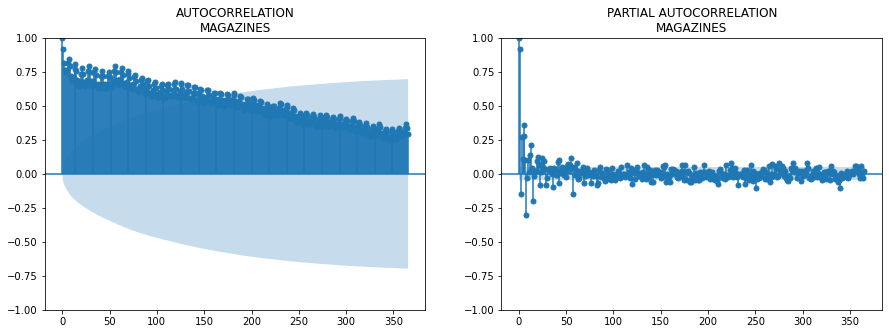

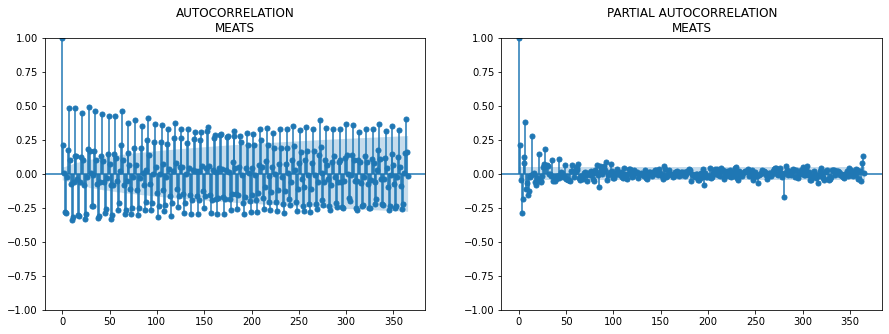

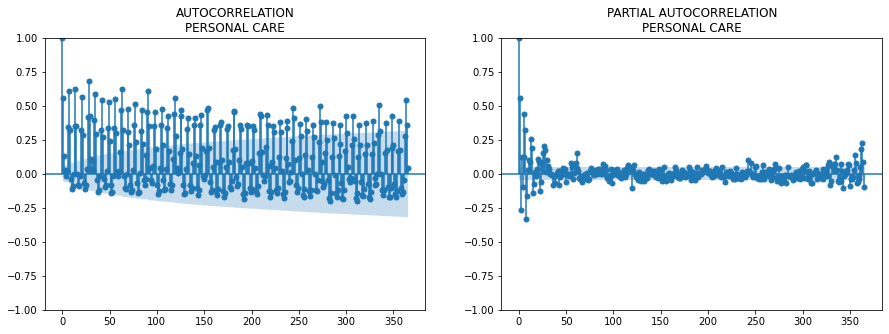

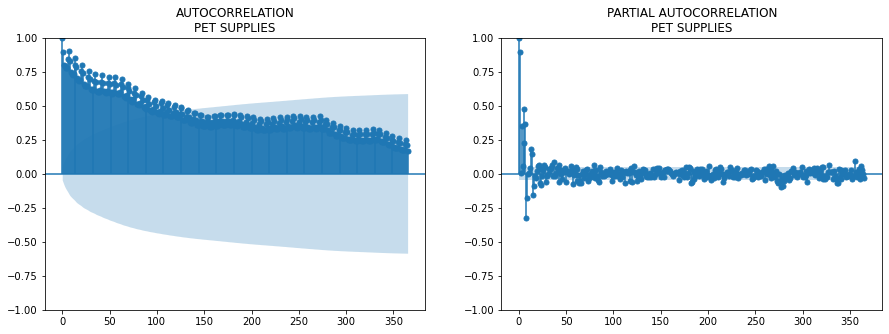

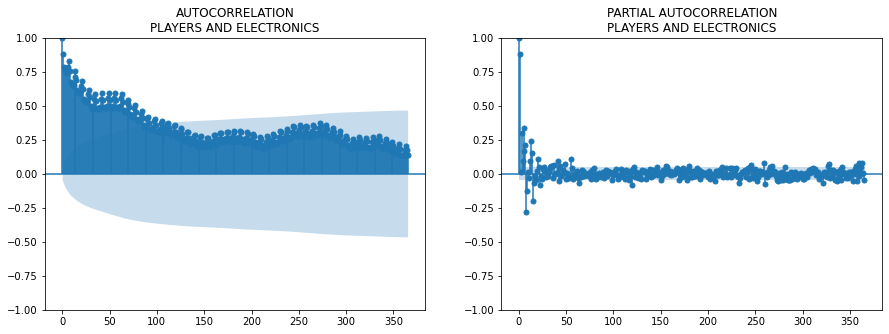

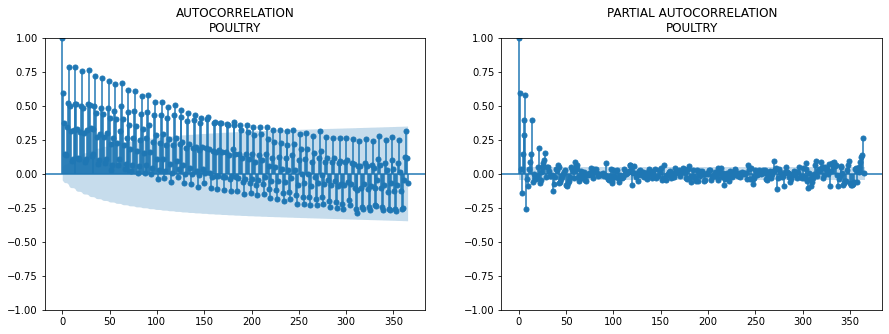

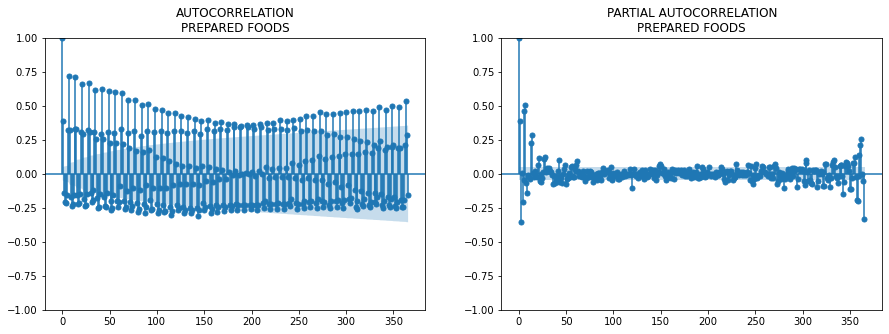

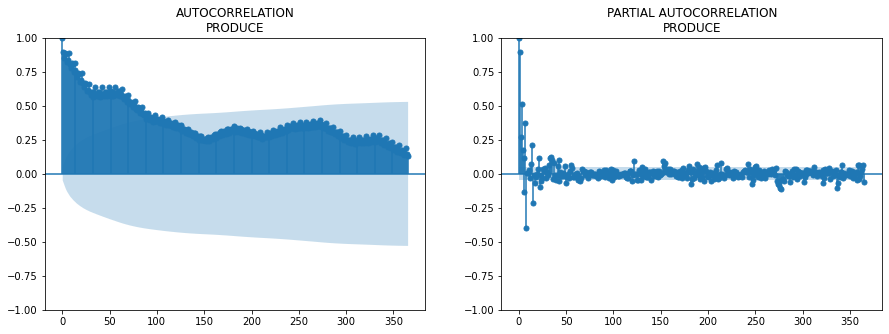

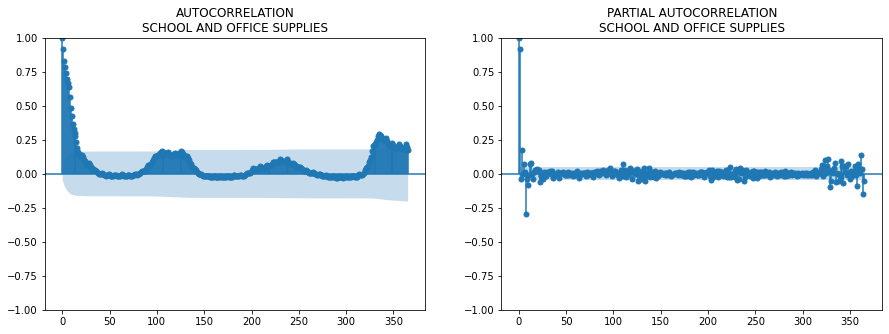

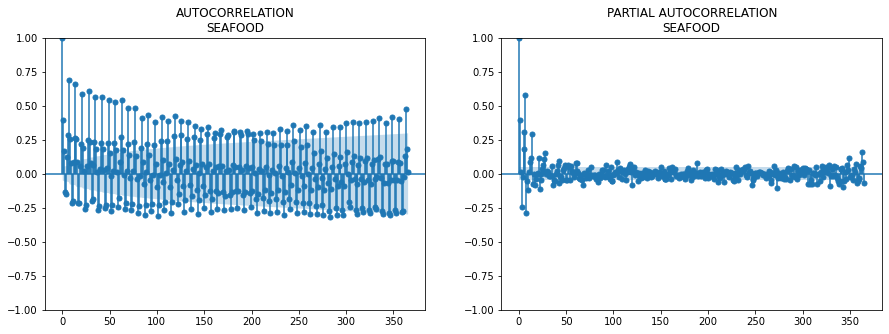

In [64]:
date_fam_sales = df[(df.sales.notnull())].groupby(["date", "family"]).sales.mean().reset_index().set_index("date")
fam = date_fam_sales.family.unique()
for num, i in enumerate(date_fam_sales.family.unique()):
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    temp = date_fam_sales[(date_fam_sales.family == i)]
    sm.graphics.tsa.plot_acf(temp.sales, lags=365, ax=ax[0], title = "AUTOCORRELATION\n" + i)
    sm.graphics.tsa.plot_pacf(temp.sales, lags=365, ax=ax[1], title = "PARTIAL AUTOCORRELATION\n" + i)

From PACF Graph, choosing 20, 30, 45, 365, 730 as lag values as here, the values were somewhere in range

In [67]:
day_wise_Sales_of_2016_n_2017 = df[df.year.isin([2016,2017])].groupby(["year", "day_of_year"]).sales.mean().reset_index()
# plt.plot(day_wise_Sales_of_2016_n_2017, x = "day_of_year", y = "sales", color = "year", title = "Average sales for 2016 and 2017")

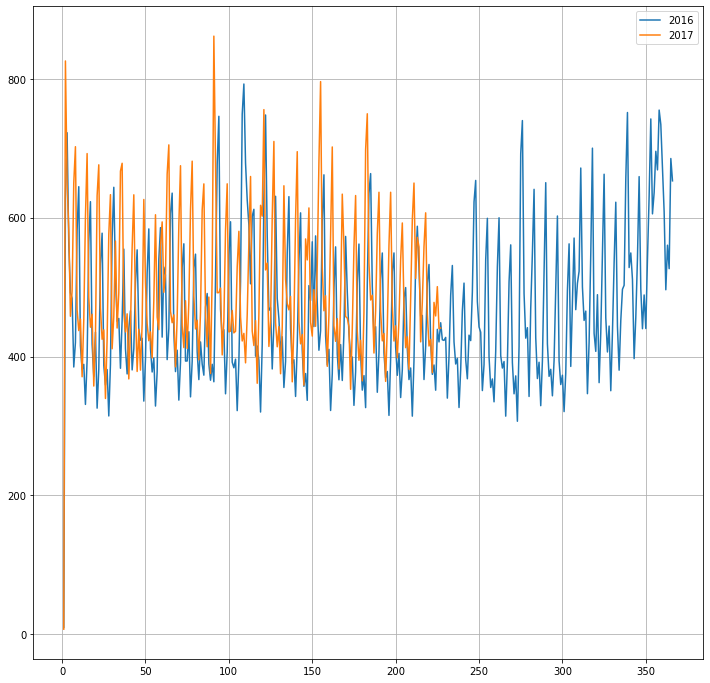

In [72]:
plt.figure(figsize=(12, 12))
for year in day_wise_Sales_of_2016_n_2017['year'].unique():
     selected_data = day_wise_Sales_of_2016_n_2017.loc[day_wise_Sales_of_2016_n_2017['year'] == year]
     plt.plot(selected_data['day_of_year'], selected_data['sales'], label=year)

plt.grid()
plt.legend()
plt.show()